Shivali Chandra <br>
1/30/16 <br>
Warmup Project Iteration 2

Inspiration 1: http://elenacuoco.altervista.org/blog/archives/1195?doing_wp_cron=1454278621.7234199047088623046875, provides a great overview of how the author figured out which values would be relevant <br>
Inspiration 2: https://triangleinequality.wordpress.com/2013/09/05/a-complete-guide-to-getting-0-79903-in-kaggles-titanic-competition-with-python/, good overview as to how to structure the code and model as decision trees. This was a really interesting approach, because it basically weighted different factors as deciding factors or questions leading to more factors (for example, starting with a male, checking the passenger class and moving to different factors based on the result). I did not implement this entirely, but read through it and the links it pointed to in order to get a better sense of how to modify my model and understand how the random classifier model actually works.  

In [1]:
%matplotlib inline
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split,StratifiedShuffleSplit,StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
import matplotlib.pyplot as plt 
import thinkplot
import thinkstats2
import string
from patsy import dmatrices,dmatrix
from sklearn.ensemble import GradientBoostingClassifier

/home/kiki/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


I incorporated my own ideas by going through and seeing how the ideas in the two articles could be combined, especially with respect to different variables. Some of the variables I used were different, because I am interested in seeing the difference that they make, not necessarily just in achieving a higher score each time. 

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The biggest impact that this blog had on my model was the fact that it parsed for title and used that to assign age, rather than using the same mean. This actually seems pretty significant because there are over 200 ages missing, and with about 900 total people that is a large portion, so trying to get the age in a closer range is important. 

In [3]:
#code from link to first blog; finds title in each name if exists and places it in a new column, called title. The titles are normalized. 
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if string.find(big_string, substring) != -1:
            return substring
    print big_string
    return np.nan

title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                'Don', 'Jonkheer']
train['Title']=train['Name'].map(lambda x: substrings_in_string(x, title_list))
test['Title']=test['Name'].map(lambda x: substrings_in_string(x, title_list))

#replacing all titles with mr, mrs, miss, master
def replace_titles(x):
    title=x['Title']
    if title in ['Mr','Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Master']:
        return 'Master'
    elif title in ['Countess', 'Mme','Mrs']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms','Miss']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    elif title =='':
        if x['Sex']=='Male':
            return 'Master'
        else:
            return 'Miss'
    else:
        return title

train['Title']=train.apply(replace_titles, axis=1)
test['Title']=test.apply(replace_titles, axis=1)

train['AgeFill']=train['Age']
test['AgeFill']=test['Age']
mean_ages = np.zeros(4)
mean_ages[0]=np.average(train[train['Title'] == 'Miss']['Age'].dropna())
mean_ages[1]=np.average(train[train['Title'] == 'Mrs']['Age'].dropna())
mean_ages[2]=np.average(train[train['Title'] == 'Mr']['Age'].dropna())
mean_ages[3]=np.average(train[train['Title'] == 'Master']['Age'].dropna())
train.loc[ (train.Age.isnull()) & (train.Title == 'Miss') ,'AgeFill'] = mean_ages[0]
train.loc[ (train.Age.isnull()) & (train.Title == 'Mrs') ,'AgeFill'] = mean_ages[1]
train.loc[ (train.Age.isnull()) & (train.Title == 'Mr') ,'AgeFill'] = mean_ages[2]
train.loc[ (train.Age.isnull()) & (train.Title == 'Master') ,'AgeFill'] = mean_ages[3]
test.loc[ (test.Age.isnull()) & (test.Title == 'Miss') ,'AgeFill'] = mean_ages[0]
test.loc[ (test.Age.isnull()) & (test.Title == 'Mrs') ,'AgeFill'] = mean_ages[1]
test.loc[ (test.Age.isnull()) & (test.Title == 'Mr') ,'AgeFill'] = mean_ages[2]
test.loc[ (test.Age.isnull()) & (test.Title == 'Master') ,'AgeFill'] = mean_ages[3]

The effort that the blog put into trying to ensure the age was accurate led me to see if I should implement a more complex way of filling in missing Embarked values. However, when I run: 

In [4]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
AgeFill          0
dtype: int64

I see that there are actually only 2 passengers for whom the starting point is unknown. Thus, it seems safe to simply fill in those values with 'S', the most common location.
I will continue cleaning the data as I did earlier, dropping the columns which no longer matter and replacing the Embarked and Sex values with integers. I will also combine the SibSp and Parch columns into one Family column. 
Unlike the blogpost, I also converted the title column into integer values, to see if that makes any impact on the final survival predictions. 

In [5]:
train['FamilySize'] = train['SibSp'] + train['Parch']
train['NameLength'] = train['Name'].apply(lambda x: len(x))
train['Embarked'] = train['Embarked'].fillna('S')
train.loc[train['Embarked'] == 'S', 'Embarked'] = 0
train.loc[train['Embarked'] == 'C', 'Embarked'] = 1
train.loc[train['Embarked'] == 'Q', 'Embarked'] = 2
train.loc[train['Sex'] == 'male', 'Sex'] = 1
train.loc[train['Sex'] == 'female', 'Sex'] = 0
test['FamilySize'] = test['SibSp'] + test['Parch']
test['NameLength'] = test['Name'].apply(lambda x: len(x))
test['Embarked'] = test['Embarked'].fillna('S')
test.loc[test['Embarked'] == 'S', 'Embarked'] = 0
test.loc[test['Embarked'] == 'C', 'Embarked'] = 1
test.loc[test['Embarked'] == 'Q', 'Embarked'] = 2
test.loc[test['Sex'] == 'male', 'Sex'] = 1
test.loc[test['Sex'] == 'female', 'Sex'] = 0

test.loc[ test.Title == 'Miss','Title'] = 4
test.loc[ test.Title == 'Mrs','Title'] = 3
test.loc[ test.Title == 'Mr','Title'] = 1
test.loc[ test.Title == 'Master','Title'] = 2
train.loc[ train.Title == 'Miss','Title'] = 4
train.loc[ train.Title == 'Mrs','Title'] = 3
train.loc[ train.Title == 'Mr','Title'] = 1
train.loc[ train.Title == 'Master','Title'] = 2

train = train.drop(['Name','Age','Cabin','Ticket','SibSp','Parch'], axis=1)
test = test.drop(['Name','Age','Cabin','Ticket','SibSp','Parch'], axis=1)

In [6]:
train.describe()

,PassengerId,Survived,Pclass,Fare,AgeFill,FamilySize,NameLength
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,32.204208,29.819131,0.904602,26.965208
std,257.353842,0.486592,0.836071,49.693429,13.285423,1.613459,9.281607
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,12.000000
25%,223.500000,0.000000,2.000000,7.910400,21.835616,0.000000,20.000000
50%,446.000000,0.000000,3.000000,14.454200,30.000000,0.000000,25.000000
75%,668.500000,1.000000,3.000000,31.000000,35.841667,1.000000,30.000000
max,891.000000,1.000000,3.000000,512.329200,80.000000,10.000000,82.000000


While all the values of the train data are filled in, I realize that it is possible that the fare may be unknown for a passenger. Thus, I will use the Pclass to predict a more accurate value for fare. 

In [7]:
p1 = train[train.Pclass == 1]
p2 = train[train.Pclass == 2]
p3 = train[train.Pclass == 3]
train.loc[train.Fare.isnull() & (train.Pclass == 1), 'Fare'] = p1.Fare.mean()
train.loc[train.Fare.isnull() & (train.Pclass == 2), 'Fare'] = p2.Fare.mean()
train.loc[train.Fare.isnull() & (train.Pclass == 3), 'Fare'] = p3.Fare.mean()
test.loc[test.Fare.isnull() & (test.Pclass == 1), 'Fare'] = p1.Fare.mean()
test.loc[test.Fare.isnull() & (test.Pclass == 2), 'Fare'] = p2.Fare.mean()
test.loc[test.Fare.isnull() & (test.Pclass == 3), 'Fare'] = p3.Fare.mean()

Now that we have cleaner data, of the first suggestions of the first blog was to make plots of age and other characteristics to see if there was any correlation: 

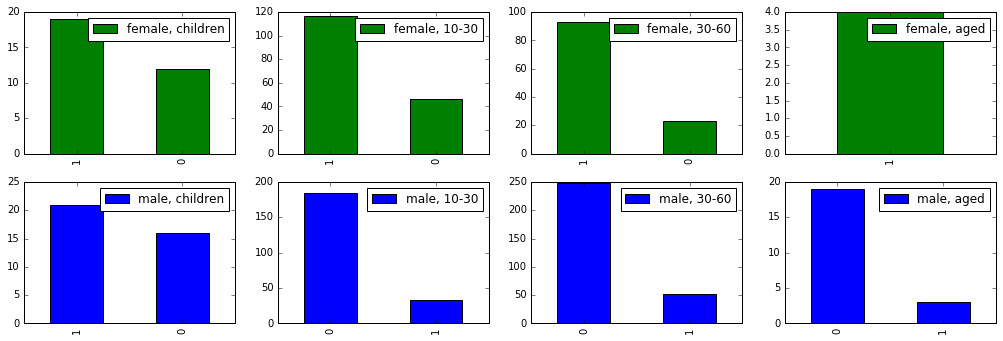

In [8]:
female = train[train.Sex == 0]
male = train[train.Sex == 1]
fig = plt.figure(figsize=(20,6))
 
plt.subplots_adjust(bottom=0.1, right=0.8, top=2)    

##gender and age
#female
ax1 = fig.add_subplot(5,4,12)
female_aged = female.Survived[female.AgeFill >= 60].value_counts()
female_aged.plot(kind='bar', color='green', label='female, aged')
plt.legend(loc='best')

ax2 = fig.add_subplot(5,4,9)
female_child = female.Survived[female.AgeFill <= 10].value_counts()
female_child.plot(kind='bar', color='green', label='female, children')
plt.legend(loc='best')

ax3 = fig.add_subplot(5,4,10)
female_midage = female.Survived[female.AgeFill>10][female.AgeFill<=30].value_counts()
female_midage.plot(kind='bar', color='green', label='female, 10-30')
plt.legend(loc='best')

ax4 = fig.add_subplot(5,4,11)
female_middleage = female.Survived[female.AgeFill>30][female.AgeFill<60].value_counts()
female_middleage.plot(kind='bar', color='green', label='female, 30-60')
plt.legend(loc='best')
 
#male
 
ax5 = fig.add_subplot(5,4,16)
male_aged = male.Survived[male.AgeFill >= 60].value_counts()
male_aged.plot(kind='bar', label='male, aged')
plt.legend(loc='best')

ax6 = fig.add_subplot(5,4,13)
male_child = male.Survived[male.AgeFill <= 10].value_counts()
male_child.plot(kind='bar', label='male, children')
plt.legend(loc='best')

ax7 = fig.add_subplot(5,4,14)
male_midage = male.Survived[male.AgeFill>10][male.AgeFill<=30].value_counts()
male_midage.plot(kind='bar', label='male, 10-30')
plt.legend(loc='best') 

ax8 = fig.add_subplot(5,4,15)
male_middleage = male.Survived[male.AgeFill>30][male.AgeFill<60].value_counts()
male_middleage.plot(kind='bar', label='male, 30-60') 
plt.legend(loc='best')

plt.show()

From this we gain some very interesting and potentially useful information: 
- the four aged females all survived
- female children had slightly under 2/3 chance of survival, not as high as I would have suspected. On the other hand, females between 10-30 had around a 3/4 chance, while females between 30-60 had about a 4/5 chance of survival
- male children had the best chance of surviving, with men between 30-60 next (about a 1/5 chance)

Next, checking once again the passenger class and gender correlation: 

/home/kiki/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


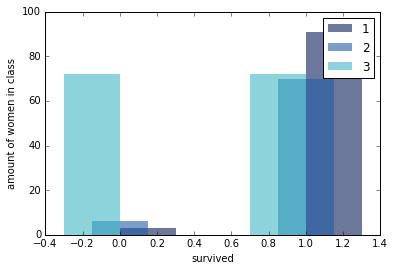

In [9]:
hist = thinkstats2.Hist(female[train.Pclass == 1].Survived)
hist1 = thinkstats2.Hist(female[train.Pclass == 2].Survived)
hist2 = thinkstats2.Hist(female[train.Pclass == 3].Survived)
thinkplot.PrePlot(3)
thinkplot.Hist(hist, align='left', width=0.3, label='1')
thinkplot.Hist(hist1, align='center', width=0.3, label='2')
thinkplot.Hist(hist2, align='right', width=0.3, label='3')
thinkplot.Show(xlabel='survived', ylabel='amount of women in class')

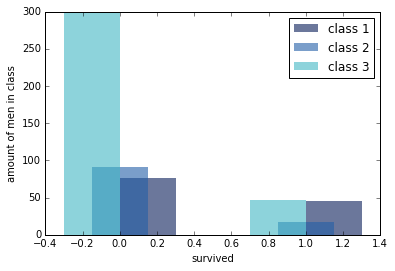

In [10]:
hist = thinkstats2.Hist(male[train.Pclass == 1].Survived)
hist1 = thinkstats2.Hist(male[train.Pclass == 2].Survived)
hist2 = thinkstats2.Hist(male[train.Pclass == 3].Survived)
thinkplot.PrePlot(3)
thinkplot.Hist(hist, align='left', width=0.3, label='class 1')
thinkplot.Hist(hist1, align='center', width=0.3, label='class 2')
thinkplot.Hist(hist2, align='right', width=0.3, label='class 3')
thinkplot.Show(xlabel='survived', ylabel='amount of men in class')

For the females, it appears there is a stronger correlation between class and survival; nearly all high class and middle class females survived, while there was about a 50-50 split between the third class, which was given lower priority during the sinking. <br>
For the males there is certainly a higher ratio of high class and middle class males who survived, but it is not as significant. <br>
Because of this correlation between age, gender, and class I will try to incorporate that into my model. 

In [11]:
predictors = ["Pclass", "Sex", "AgeFill", "Fare", "Embarked", "NameLength", "FamilySize", "Title"]

# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=10, min_samples_leaf=5)
# Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)
scores = cross_validation.cross_val_score(alg, train[predictors], train["Survived"], cv=3)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.82379349046


Before adding the new title column the mean was around 0.81, so it looks like my decision to add the column in was a good choice. Next, I will try adding columns to differentiate sex, age, and class, to see if that makes a difference. The weightings are based off of the probability of each section surviving based on the train results.

In [12]:
train['SexClass'] = train['Sex']
"""train.loc[ (train.Sex == 0) & (train.Pclass == 1) & (train.AgeFill>30) & (train.AgeFill<60),'SexClass'] = 100
train.loc[ (train.Sex == 0) & (train.Pclass == 1) & ((train.AgeFill>10) & (train.AgeFill<30) | (train.AgeFill>60)),'SexClass'] = 25
train.loc[ (train.Sex == 0) & (train.Pclass == 1) & (train.AgeFill<10),'SexClass'] = 40

train.loc[ (train.Sex == 0) & (train.Pclass == 2) & (train.AgeFill>30) & (train.AgeFill<60),'SexClass'] = 9
train.loc[ (train.Sex == 0) & (train.Pclass == 2) & (train.AgeFill>10) & (train.AgeFill<30),'SexClass'] = 8
train.loc[ (train.Sex == 0) & (train.Pclass == 2) & (train.AgeFill<10),'SexClass'] = 7
train.loc[ (train.Sex == 0) & (train.Pclass == 2) & (train.AgeFill>60),'SexClass'] = 6

train.loc[ (train.Sex == 0) & (train.Pclass == 3) ,'SexClass'] = 5

train.loc[ (train.Sex == 1) & (train.Pclass == 1) & (train.AgeFill>30) & (train.AgeFill<60),'SexClass'] = 4
train.loc[ (train.Sex == 1) & (train.Pclass == 1) & ((train.AgeFill>10) & (train.AgeFill<30) | (train.AgeFill>60)),'SexClass'] = 3
train.loc[ (train.Sex == 1) & (train.Pclass == 1) & (train.AgeFill<10),'SexClass'] = 20"""

train.loc[ (train.Sex == 0) & (train.Pclass == 1) ,'SexClass'] = 5
train.loc[ (train.Sex == 0) & (train.Pclass == 2) ,'SexClass'] = 4
train.loc[ (train.Sex == 0) & (train.Pclass == 3) ,'SexClass'] = 3
train.loc[ (train.Sex == 1) & (train.Pclass == 1) ,'SexClass'] = 2
train.loc[ (train.Sex == 1) & (train.Pclass == 2) ,'SexClass'] = 1
train.loc[ (train.Sex == 1) & (train.Pclass == 3) ,'SexClass'] = 0

test['SexClass'] = test['Sex']
"""test.loc[ (test.Sex == 0) & (test.Pclass == 1) & (test.AgeFill>30) & (test.AgeFill<60),'SexClass'] = 100
test.loc[ (test.Sex == 0) & (test.Pclass == 1) & ((test.AgeFill>10) & (test.AgeFill<30) | (test.AgeFill>60)),'SexClass'] = 25
test.loc[ (test.Sex == 0) & (test.Pclass == 1) & (test.AgeFill<10),'SexClass'] = 40

test.loc[ (test.Sex == 0) & (test.Pclass == 2) & (test.AgeFill>30) & (test.AgeFill<60),'SexClass'] = 9
test.loc[ (test.Sex == 0) & (test.Pclass == 2) & (test.AgeFill>10) & (test.AgeFill<30),'SexClass'] = 8
test.loc[ (test.Sex == 0) & (test.Pclass == 2) & (test.AgeFill<10),'SexClass'] = 7
test.loc[ (test.Sex == 0) & (test.Pclass == 2) & (test.AgeFill>60),'SexClass'] = 6

test.loc[ (test.Sex == 0) & (test.Pclass == 3) ,'SexClass'] = 5

test.loc[ (test.Sex == 1) & (test.Pclass == 1) & (test.AgeFill>30) & (test.AgeFill<60),'SexClass'] = 4
test.loc[ (test.Sex == 1) & (test.Pclass == 1) & ((test.AgeFill>10) & (test.AgeFill<30) | (test.AgeFill>60)),'SexClass'] = 3
test.loc[ (test.Sex == 1) & (test.Pclass == 1) & (test.AgeFill<10),'SexClass'] = 20"""

test.loc[ (test.Sex == 0) & (test.Pclass == 1) ,'SexClass'] = 5
test.loc[ (test.Sex == 0) & (test.Pclass == 2) ,'SexClass'] = 4
test.loc[ (test.Sex == 0) & (test.Pclass == 3) ,'SexClass'] = 3
test.loc[ (test.Sex == 1) & (test.Pclass == 1) ,'SexClass'] = 2
test.loc[ (test.Sex == 1) & (test.Pclass == 2) ,'SexClass'] = 1
test.loc[ (test.Sex == 1) & (test.Pclass == 3) ,'SexClass'] = 0

I played around a bit to see how to achieve the best means of weighting the values in this column - one thing I did not have a chance to try was weighting by percentages of survival in the training data. 

In [13]:
predictors = ["Pclass", "Sex", "AgeFill", "Fare", "Embarked", "NameLength", "FamilySize", "Title", "SexClass"]

# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, min_samples_leaf=5)
# Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)
scores = cross_validation.cross_val_score(alg, train[predictors], train["Survived"], cv=25)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.835137254902


Overall, I saw values for the mean range from around 0.819 to 0.837, so there was a definite improvement. However, when actually testing this in Kaggle, I actually went down in accuracy, from 0.7799 to around 0.75120 and 0.7713. Thus, I think I will also try changing the model variables to see if that helps.

In [14]:
alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=5)
# Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)
scores = cross_validation.cross_val_score(alg, train[predictors], train["Survived"], cv=25)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.836311858077


In changing model variables, the mean improved at most by 0.02. However, the Kaggle score did not improve, so that suggests that I need to change my model to make it more accurate. 

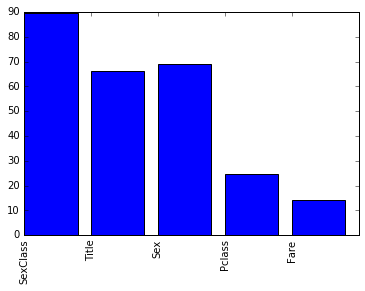

0.840855275444


In [26]:
# Perform feature selection
selector = SelectKBest(f_classif, k='all')
selector.fit(train[predictors], train["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

# Pick only the best features.
#predictors = ["Pclass", "Sex", "Fare", "Title"]
predictors = ["SexClass", "Title", "Sex", "Pclass", "Fare"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=5)
# Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)
scores = cross_validation.cross_val_score(alg, train[predictors], train["Survived"], cv=25)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

By seeing which factors had the largest effect, I was able to select only those to use and get a pretty high result with my train data (0.841). However, in Kaggle my score actually remained the same when I submitted it. So, the last thing I tried was to change the type of model by using three algorithms, gradient boosting and logistic regression along with random forest, and taking the average of the three. 

In [35]:
# The algorithms we want to ensemble.
# We're using the more linear predictors for the logistic regression, and everything with the gradient boosting classifier.
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), ["Sex", "NameLength", "SexClass", "Pclass", "Fare", "Embarked", "Title", "FamilySize"]],
    [RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=5), ["Sex", "NameLength", "SexClass", "Pclass", "Fare", "Embarked", "Title", "FamilySize"]],
    [LogisticRegression(random_state=1), ["Sex", "NameLength", "SexClass", "Pclass", "Fare", "Embarked", "Title", "FamilySize"]]
]

# Initialize the cross validation folds
kf = KFold(train.shape[0], n_folds=3, random_state=1)

predictions = []
for train1, test1 in kf:
    train_target = train["Survived"].iloc[train1]
    full_test_predictions = []
    # Make predictions for each algorithm on each fold
    for alg, predictors in algorithms:
        # Fit the algorithm on the training data.
        alg.fit(train[predictors].iloc[train1,:], train_target)
        # Select and predict on the test fold.  
        # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
        test_predictions = alg.predict_proba(train[predictors].iloc[test1,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    # Use a simple ensembling scheme -- just average the predictions to get the final classification.
    test_predictions = (full_test_predictions[0] + full_test_predictions[1] + full_test_predictions[2]) / 3
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)

# Compute accuracy by comparing to the training data.
accuracy = sum(predictions[predictions == train["Survived"]]) / len(predictions)
print(accuracy)

0.813692480359


/home/kiki/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:35: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


In [30]:
full_predictions = []
for alg, predictors in algorithms:
    # Fit the algorithm using the full training data.
    alg.fit(train[predictors], train["Survived"])
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
    predictions = alg.predict_proba(test[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

# The gradient boosting classifier generates better predictions, so we weight it higher.
predictions = (full_predictions[0] * 5 + full_predictions[1]) / 4
predictions[predictions <= .5] = 0
predictions[predictions > .5] = 1
predictions = predictions.astype(int)
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": predictions
    })

In [28]:
submission.to_csv('kaggle.csv', index=False)

In the end, this also did not improve my score, but I learned much more about how the models actually work. I think that implementing my own column, 'SexClass', helped my model significantly, but I need to figure out a better method of weighting. Overall, I think that my score on Kaggle did not improve because right now the weighting is very tailored to the train data, and is not necessarily very adaptable. In order to increase my scores with this model from 0.77033 to beat my highest score of 0.7799 and improve it in general, the weighting of different factors and variables is definitely where I would start. 